In [1]:
from PIL import Image
import numpy as np
import cupy as cp
from matplotlib import cm
from IPython.display import display

In [2]:
def compute_coordinates(res, size):
    """Return an array of shape (res) containing the coordinates of a sampling lattice."""
    pitch = size / res
    indices = cp.arange(res)
    return (-size/2 + pitch/2) + indices * pitch

def convolution_matrix(x_in, x_out, kernel):
    """Return a convolution matrix with given kernel."""
    return kernel(x_out[..., np.newaxis] - x_in)

def cosine_signal(x, frequency, phase=0.0):
    """Sample a cosine with given frequency and phase at given sampling coordinates."""
    return cp.cos((x * frequency + phase) * 2 * np.pi)/2 + 0.5

def display_image(values, color_map=None):
    """Display an array of values as an image using a color map."""
    color_values = cm.get_cmap(color_map)(values/np.amax(values))
    uint8_values = (color_values * 255).astype(np.uint8)
    display(Image.fromarray(uint8_values).transpose(Image.ROTATE_90))

In [3]:
pixel_size = 31

low_res = 33
high_res = low_res * pixel_size

impulse = cp.array([0.0]*(pixel_size//2) + [1.0] + [0.0]*(pixel_size//2))

low_res_coords  = compute_coordinates( low_res, low_res)
high_res_coords = compute_coordinates(high_res, low_res)

sinc_kernel = cp.sinc(high_res_coords)
blur_kernel = cp.exp(-cp.square(high_res_coords))

sinc_matrix = convolution_matrix(low_res_coords, high_res_coords, kernel=cp.sinc)
blur_matrix = convolution_matrix(high_res_coords, high_res_coords, kernel=lambda x: cp.exp(-cp.square(x)))
blur_matrix /= cp.amax(cp.sum(blur_matrix, axis=0))

low_signal_4 = cosine_signal(low_res_coords, 0.4) * 0.8 + 0.2
low_signal_5 = cosine_signal(low_res_coords, 0.5) * 0.8 + 0.2
low_signal_6 = cosine_signal(low_res_coords, 0.6) * 0.8 + 0.2
low_signal_4_6 = (cp.sinc(0.4) * low_signal_4 + cp.sinc(0.6) * low_signal_6) / (cp.sinc(0.4) + cp.sinc(0.6))

high_signal_4 = cosine_signal(high_res_coords, 0.4) * 0.8 + 0.2
high_signal_5 = cosine_signal(high_res_coords, 0.5) * 0.8 + 0.2
high_signal_6 = cosine_signal(high_res_coords, 0.6) * 0.8 + 0.2
high_signal_4_6 = (cp.sinc(0.4) * high_signal_4 + cp.sinc(0.6) * high_signal_6) / (cp.sinc(0.4) + cp.sinc(0.6))

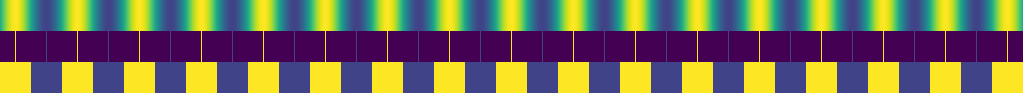

In [4]:
img = cp.stack((
    high_signal_5,
    cp.kron(low_signal_5, impulse),
    cp.repeat(low_signal_5, pixel_size)
    ), axis=1)

display_image(cp.repeat(cp.flip(img, axis=1), pixel_size, axis=1).get())

Figure 1
* a) Signal with frequency 0.5 (at Nyquist limit)
* b) Sampling of signal (a)
* c) Signal reconstructed with box kernel from samples on (b)

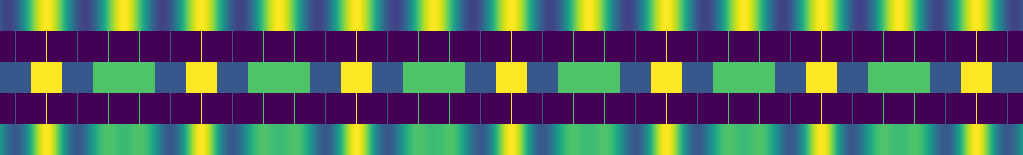

In [5]:
img = cp.stack((
    high_signal_4,
    cp.kron(low_signal_4, impulse),
    cp.repeat(low_signal_4, pixel_size),
    cp.kron(low_signal_4_6, impulse),
    high_signal_4_6
    ), axis=1)

display_image(cp.repeat(cp.flip(img, axis=1), pixel_size, axis=1).get())

Figure 2
* a) Signal with frequency 0.4 (below Nyquist limit)
* b) Sampling of signal (a)
* c) Signal reconstructed with box kernel from samples on (b)
* d) Sampling of signal (e)
* e) Signal with a mix of frequencies 0.4 and 0.6

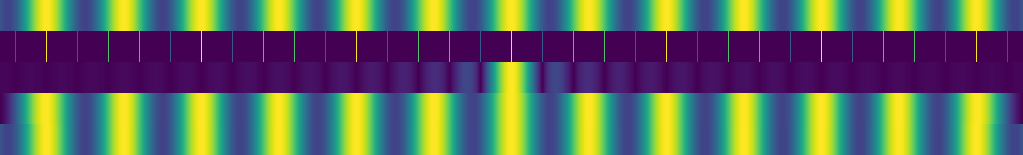

In [6]:
img = cp.stack((
    high_signal_4,
    cp.kron(low_signal_4, impulse),
    cp.abs(sinc_kernel),
    cp.clip(sinc_matrix @ low_signal_4, 0.0, 1.0),
    high_signal_4
    ), axis=1)

display_image(cp.repeat(cp.flip(img, axis=1), pixel_size, axis=1).get())

Figure 3
* a) Signal with frequency 0.4 (below Nyquist limit)
* b) Sampling of signal (a)
* c) Sinc kernel (absolute value)
* d) Convolution of (b) and (c)
* e) Same as (a), for ease of comparison

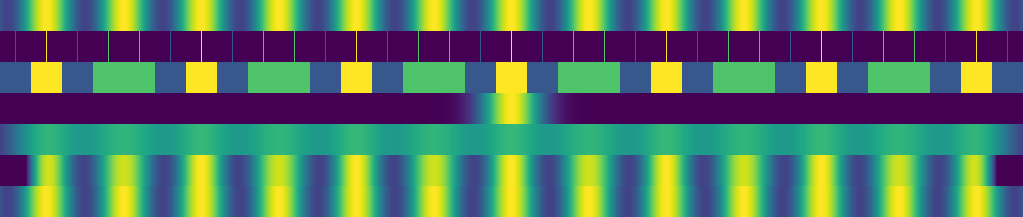

In [7]:
blured_signal = cp.clip(blur_matrix @ cp.repeat(low_signal_4, pixel_size), 0.0, 1.0)

contrast_signal = blured_signal - cp.amin(blured_signal[4*pixel_size:-4*pixel_size])
contrast_signal = contrast_signal / cp.amax(contrast_signal[4*pixel_size:-4*pixel_size]) * 0.8 + 0.2

img = cp.stack((
    high_signal_4,
    cp.kron(low_signal_4, impulse),
    cp.repeat(low_signal_4, pixel_size),
    blur_kernel,
    blured_signal,
    contrast_signal,
    high_signal_4
    ), axis=1)

display_image(cp.repeat(cp.flip(img, axis=1), pixel_size, axis=1).get())

Figure 4
* a) Signal with frequency 0.4 (below Nyquist limit)
* b) Sampling of signal (a)
* c) Signal reconstructed with box kernel from samples on (b)
* d) Gaussian blur kernel
* e) Convolution of (c) and (d)
* f) Signal (e) with artificial contrast correction
* g) Same as (a), for ease of comparison